# Evaluation of ion suppression correction

In this notebook, I explore different measures to quantify the effect of correcting SpaceM ion intensity data for partial pixel-cell overlap.
 

In [9]:
import platform
import os
import multiprocessing
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.functions import *
from sklearn.cluster import KMeans
import re

In [10]:
project = 'Lx_Glioblastoma'

In [11]:
if platform.system() == "Darwin":
    project_path = '/Volumes/mklein/FDA_project/data'
else:
    project_path = '/home/mklein/FDA_project/data'

adata = ad.read(os.path.join(project_path, project, "batch_sm_matrix.h5ad"))
adata_cor = ad.read(os.path.join(project_path, project, "corrected_batch_sm_matrix.h5ad"))

condition_name = 'dataset_3'

In [12]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=5)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.raw = adata
    # sc.pp.log1p(adata)
    sc.pp.scale(adata)

preprocess(adata)
preprocess(adata_cor)


print(adata.shape)
print(adata_cor.shape)


(13758, 1503)
(14108, 1480)


In [13]:
included_molecules = adata.var_names.intersection(adata_cor.var_names)
included_cells = adata.obs_names.intersection(adata_cor.obs_names)
#included_cells = included_cells.intersection(adata.obs[adata.obs[condition_name].isin(['NaiveWT', 'TMDdM'])].index)
def subset_molecules(adata):
    
    return adata[included_cells, included_molecules]

adata = subset_molecules(adata)
adata_cor = subset_molecules(adata_cor)

print(adata.shape)
print(adata_cor.shape)

(6182, 1480)
(6182, 1480)


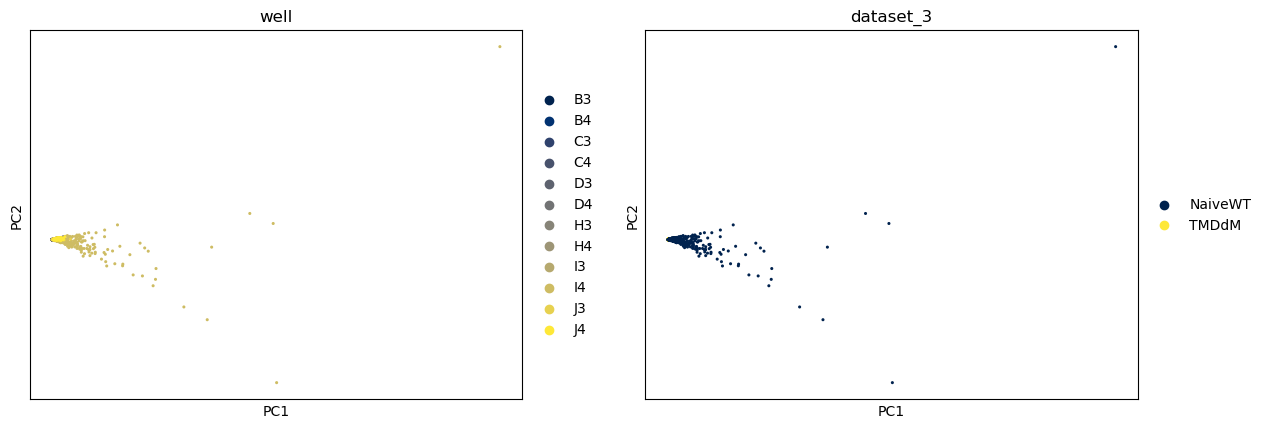

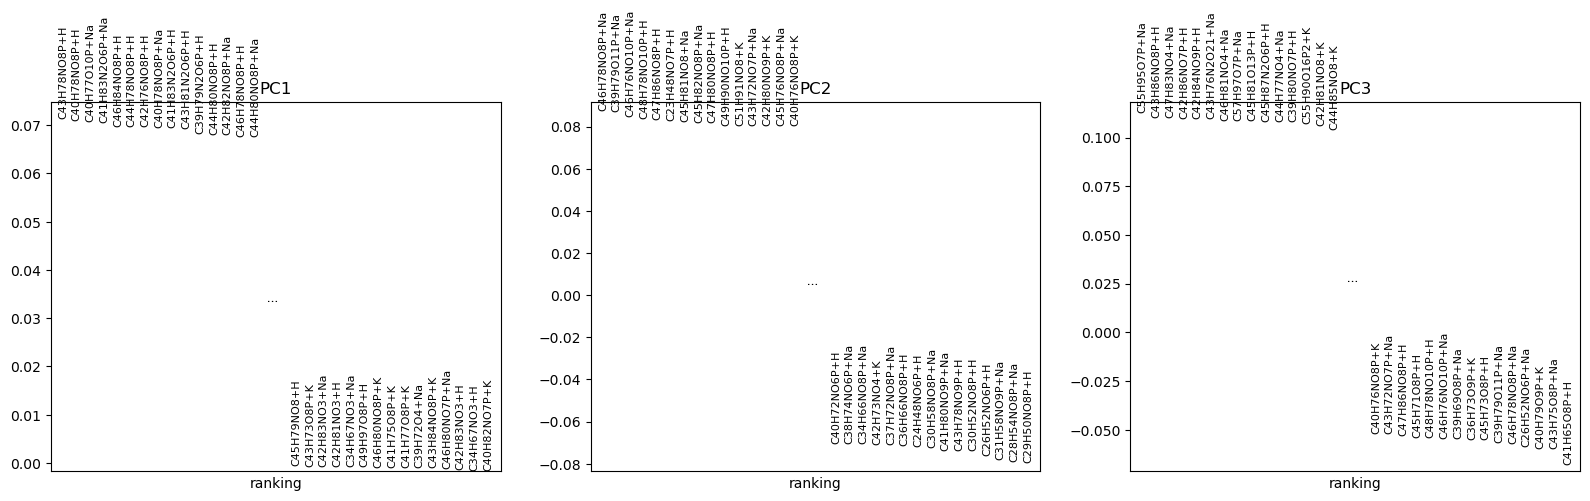

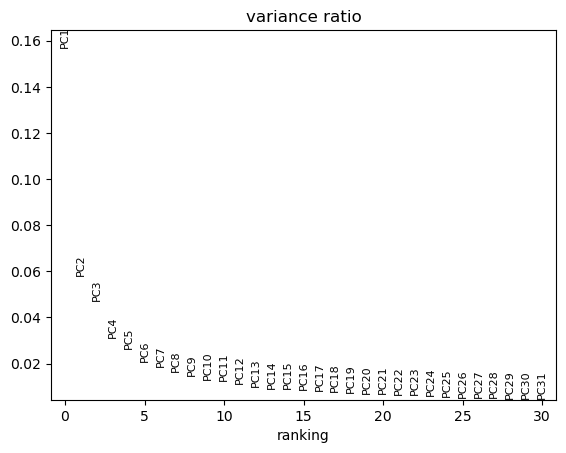

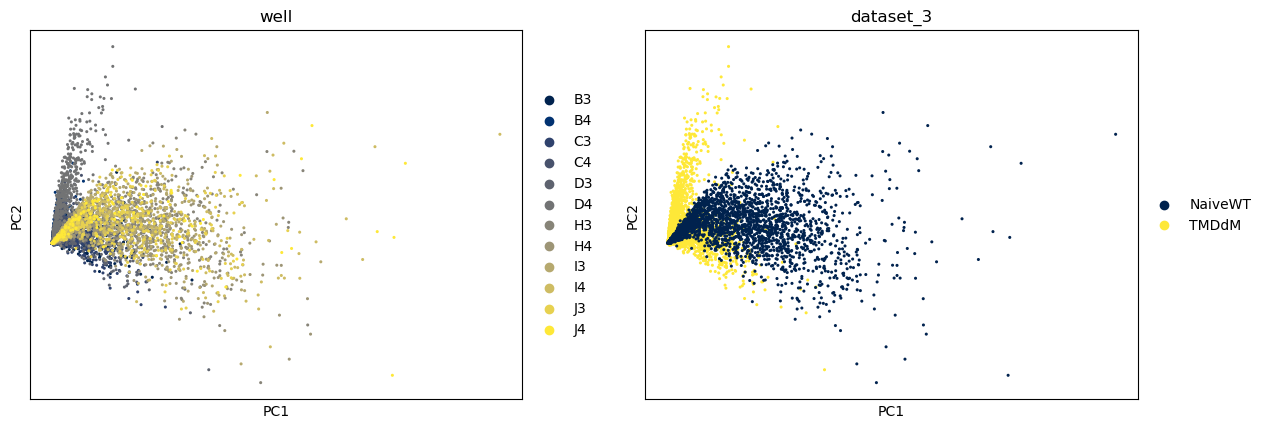

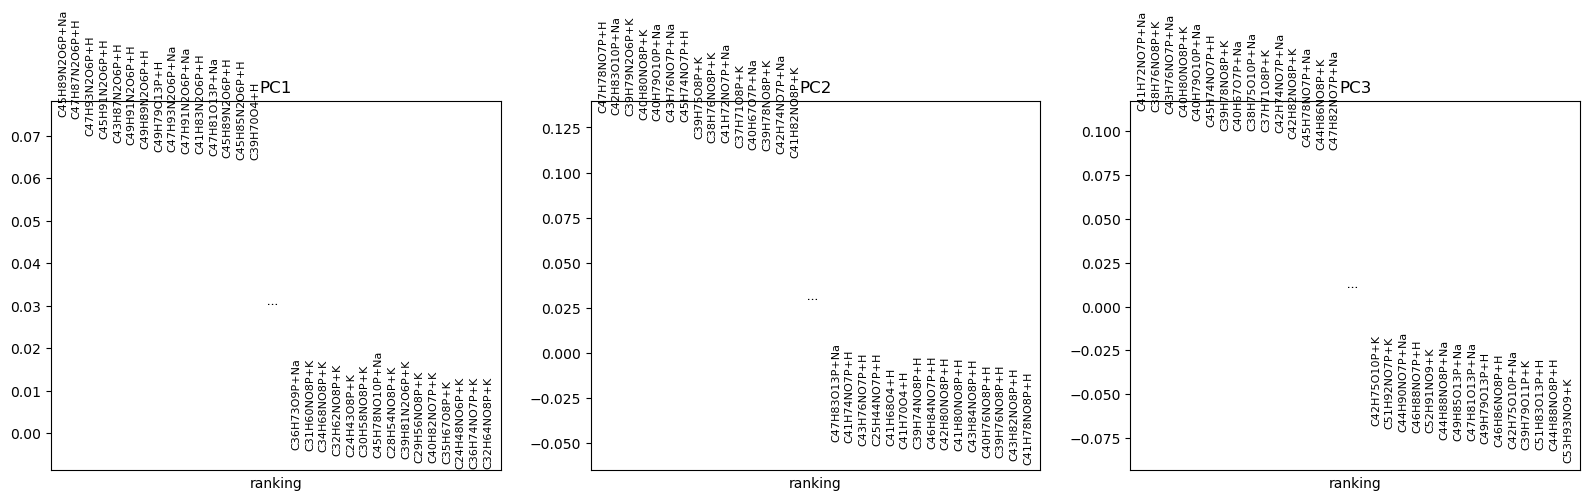

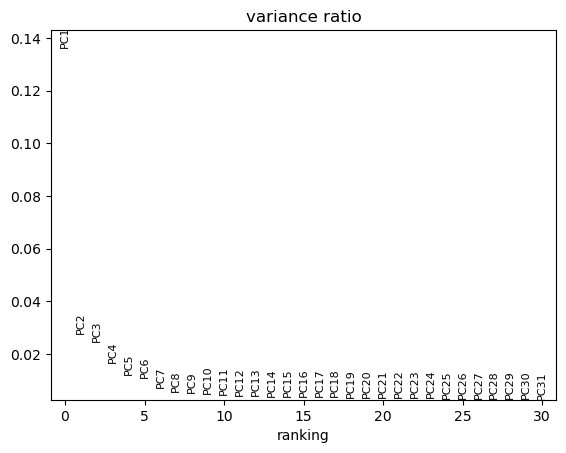

In [14]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color=['well', condition_name], palette='cividis')

dimred_pca(adata)
dimred_pca(adata_cor)

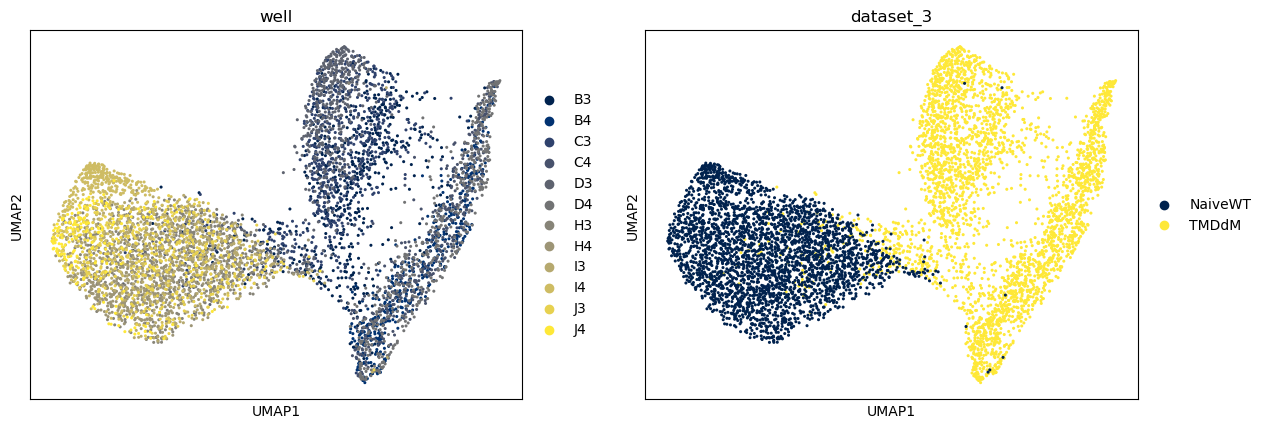

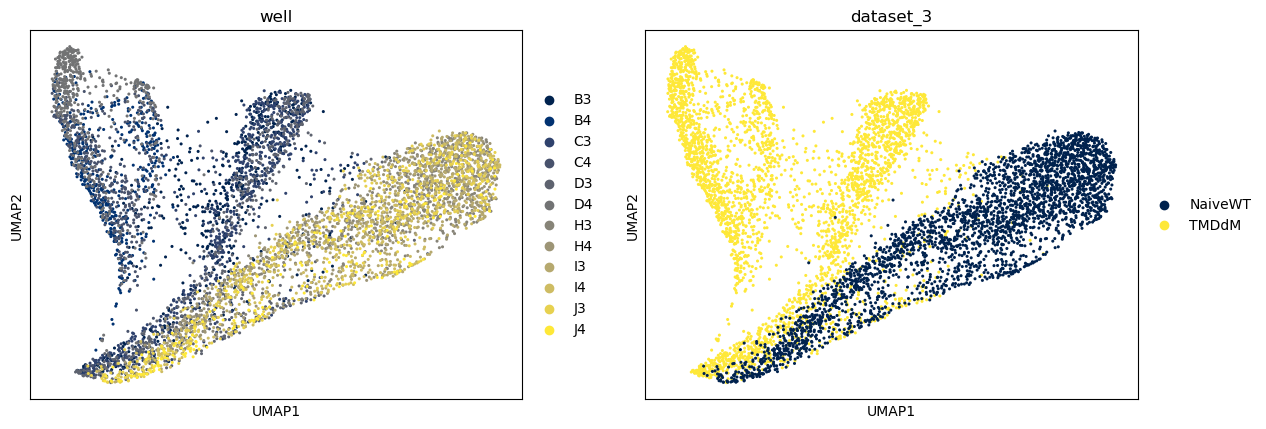

In [15]:
def dimred_umap(adata, min_dist = 0.5):
    sc.pp.neighbors(adata, n_neighbors=200, )
    sc.tl.umap(adata, min_dist=min_dist, spread=3.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color=['well', condition_name], palette='cividis')

dimred_umap(adata)
dimred_umap(adata_cor)


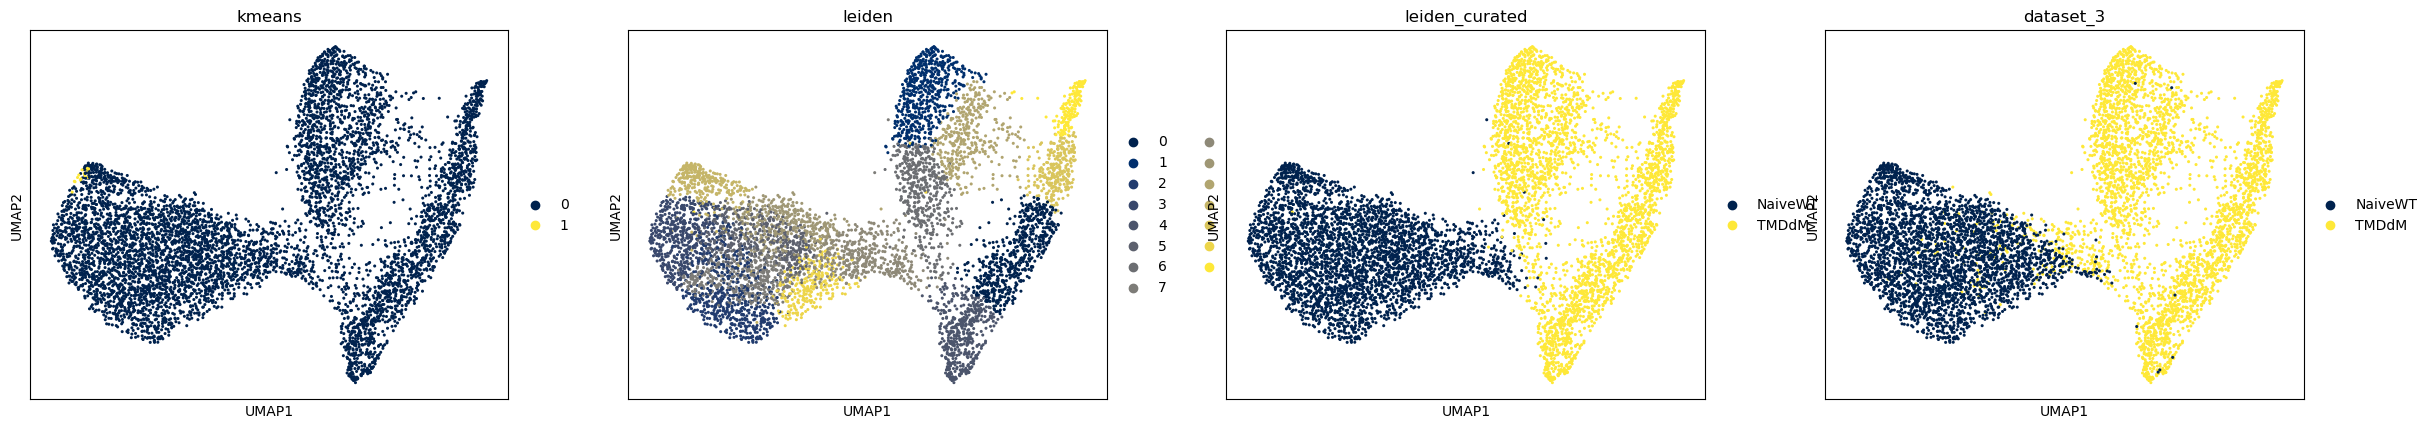

Curated leiden acccuracy score: 0.9494
KMeans completeness score: 0.1073
KMeans silhouette coefficient: 0.9196


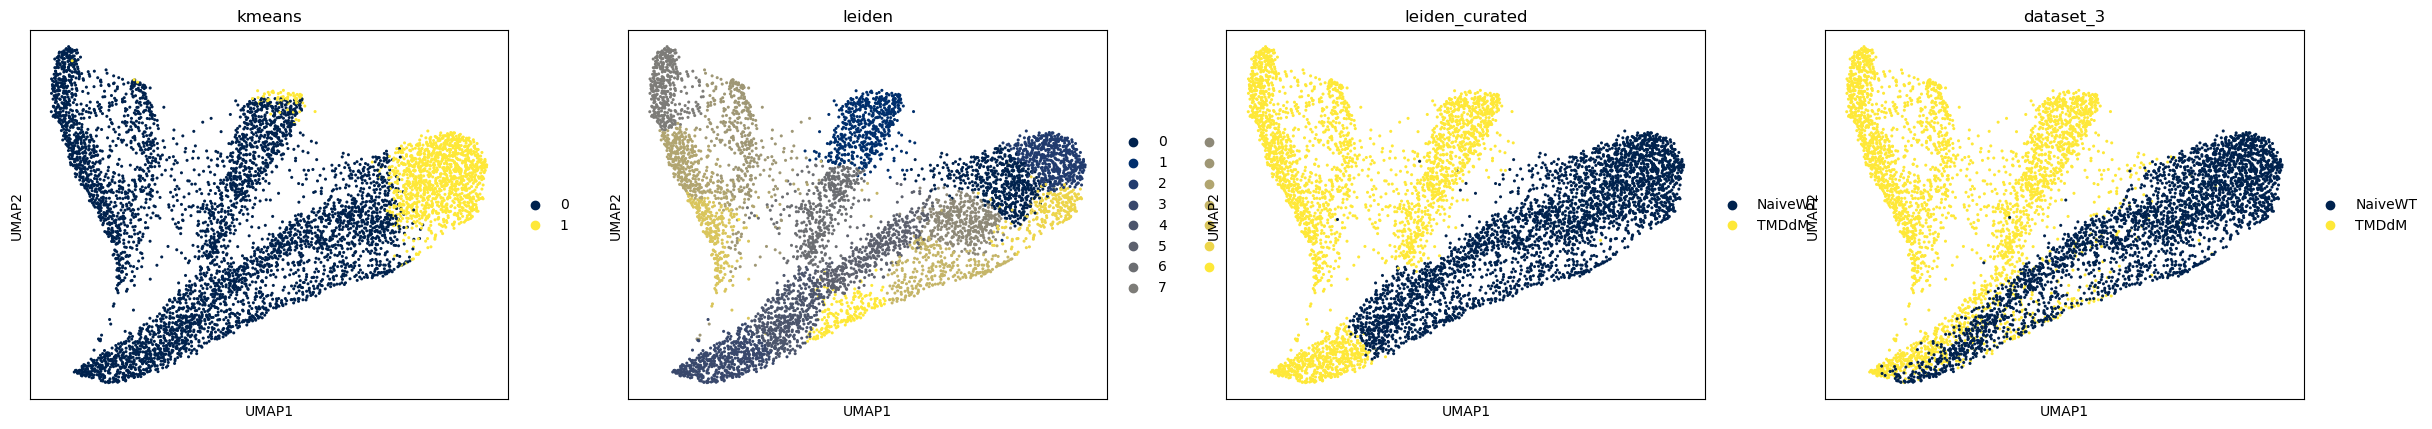

Curated leiden acccuracy score: 0.9020
KMeans completeness score: 0.2449
KMeans silhouette coefficient: 0.3997


In [16]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score, silhouette_score

def kmeans_clust(adata):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=2)

    leiden = np.array(adata.obs['leiden'].values)
    leiden_curated = np.copy(leiden)
    fc = np.array(adata.obs[condition_name].values)
    for cluster in np.unique(leiden):
        labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
        leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
    adata.obs['leiden_curated'] = leiden_curated

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'leiden_curated', condition_name], palette='cividis')
    # print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs[condition_name].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('Curated leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs[condition_name], y_pred = adata.obs['leiden_curated']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs[condition_name], adata.obs['kmeans']))
    print('KMeans silhouette coefficient: %1.4f' % silhouette_score(adata.X, adata.obs['kmeans']))

kmeans_clust(adata)
kmeans_clust(adata_cor)


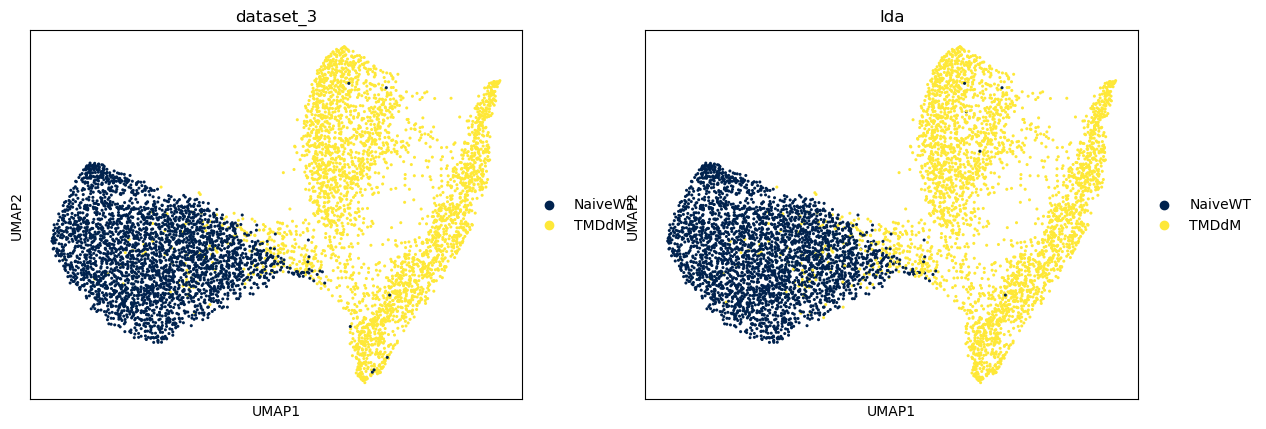

LDA accuracy after 10-fold cross-validation: 0.9545 (±0.0083)


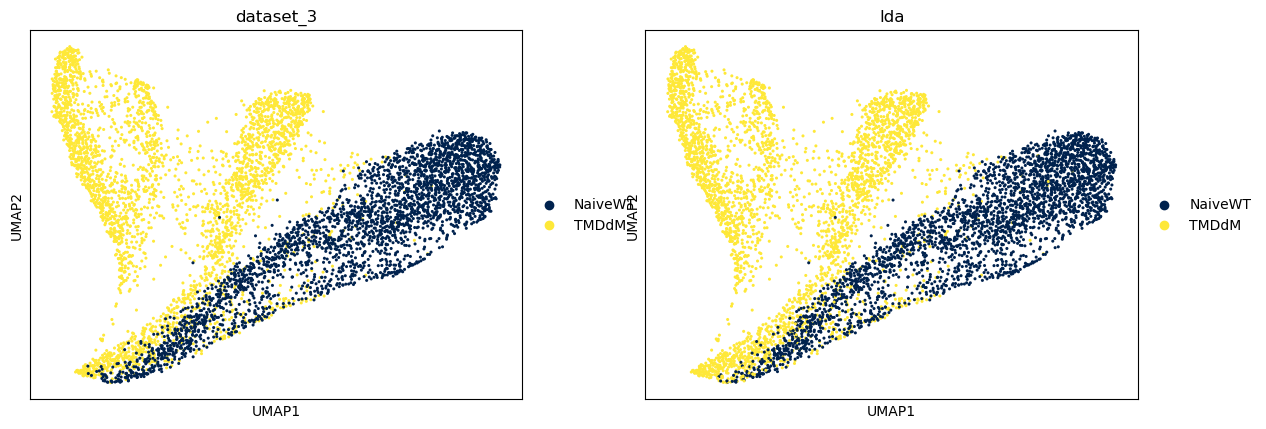

LDA accuracy after 10-fold cross-validation: 0.9539 (±0.0073)


In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def LDA(adata):
    predictors = adata.X
    result = adata.obs[condition_name]
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=multiprocessing.cpu_count())
    
    adata.obs['lda'] = model.predict(adata.X)
    sc.pl.umap(adata, color=[condition_name, 'lda'], palette='cividis')
    print("LDA accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  


LDA(adata) 
LDA(adata_cor) 

1236it [00:23, 52.52it/s]
1236it [00:21, 57.02it/s]
1236it [00:22, 55.51it/s]
1236it [00:21, 57.12it/s]


,,mean,sd,rel_neighborhood
umap_1,10,0.042558,0.142882,0.091837
umap_2,10,0.080037,0.187444,0.091837
pca_1,10,0.032770,0.129982,0.091837
pca_2,10,0.059683,0.155588,0.091837


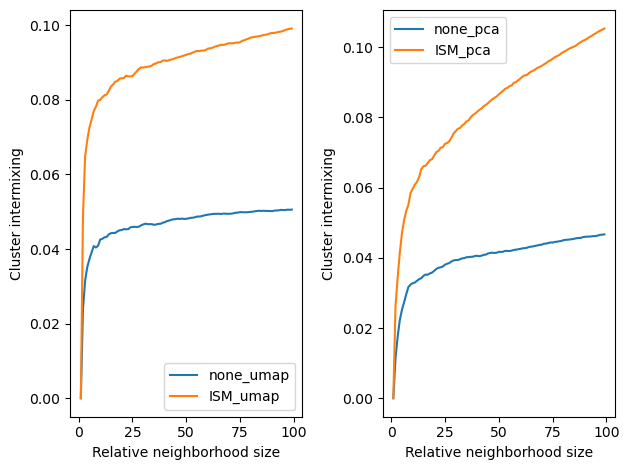

In [18]:
intermixing(adata, adata_cor, condition_name = condition_name, labels=('none', 'ISM'))